MEK: Import block

In [1]:
import numpy as np
import astropy
import scipy
import matplotlib.pyplot as plt
import emcee
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
import pymc
import corner.corner as corner
import astroML
import sklearn
import os
import time
import ultranest
import math

Optional mpi4py package is not installed.  MPI support is not available.


MEK: Collect data from pyspeckit fits

In [2]:
data = np.load("/home/kaldorme/classes/astr_8070_s25/coursework/student_folders/marykaldor/spectral_decomp/fit_uncert/56449.npy")
w = data[0]
fl = data[1]
uncert = data[2]

In [47]:
def disk(values):
    params = ['Q1',\
          #'Q2',\
          #'XIB',\
          'ANGI',\
          'XI1',\
          'XI2']
          #'BROAD']
          #'T0',\
          #'ETA',\
          #'ANGLAM',\
          #'AMP',\
          #'NARMS',\
          #'AOBS',\
          #'PITCH',\
          #'WIDTH']
          #'XISPIN',\
          #'XISPOUT']
    # MEK Convert log values back into scalar, make add XI1 to XI2 to find outer radius
    values[2] = 10**float(values[2])
    values[3] = 10**float(values[3])
    values[3] = float(values[2])+float(values[3])
    #values[5] = float(values[4])+float(values[5])
    
    # Open old file in read mode and create new file in write mode
    fin = open("./parfile_original.dat", "r")
    fout = open("./parfile.dat", "w")

    # Setting up list iterations
    i = 0

    # Setting up range over which to iterate
    j = 0
    k = len(values)-1

    # Go through text and only change given parameter's value
    # Everything else just gets rewritten to the new file
    while j<k:
        for line in fin:
            if params[j] in line:
                x = line.split()
                if params[j] == x[1]:
                    if j==11:
                        # Forcing to write the number of spiral arms in the disk as an integer
                        fout.write(line.replace(x[0], str(int(values[j]))))
                    else:
                        fout.write(line.replace(x[0], str(values[j])))
                    if params[j] == params[-1]:
                        pass
                    else:
                        j += 1
                else:
                    fout.write(line)
            else:
                fout.write(line)
    
    fin.close()
    fout.close()

    # Generate BEL profile
    os.system("./calc_profile_wave_pkg.x")
    wavelength = []
    flambda = []
    f = open('model.dat')
    lines = f.readlines()

    # Gets rid of pound symbol lines
    for line in lines:
        if line[0] == "#":
            pass
        else:
            x, y = line.split()
            y = y.strip("\n")
            x = float(x)
            y = float(y)
            wavelength.append(x)
            flambda.append(y)

    wavelength = np.array(wavelength)
    flambda = np.array(flambda)

    # Plot
    plt.figure(figsize=(16,12))
    plt.errorbar(w, fl, abs(uncert), capsize=10, label="Initial", linewidth=2)
    plt.plot(wavelength, flambda, label="Fit", linewidth=5)
    plt.legend(fontsize=30)
    plt.xlabel("Wavelength ($\AA$)", fontsize=30)
    plt.ylabel("Flux (Normalized)", fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.savefig("./56449.png")
    plt.show()
    
    return wavelength, flambda

# compute the data log-likelihood given a model
def logL(values, model=disk):
    #if values[4]>values[5]:
        #loglike = -np.inf
    y_fit = model(values)[1]
    y = fl
    u = abs(uncert)
    loglike = sum(scipy.stats.norm.logpdf(*args) for args in zip(y_fit, y, u))
    return loglike

In [48]:
params_nostring = ['Q1',\
          #'Q2',\
          #'XIB',\
          'ANGI',\
          'XI1',\
          'XI2']
          #'BROAD']
          #'T0',\
          #'ETA',\
          #'ANGLAM',\
          #'AMP',\
          #'NARMS',\
          #'AOBS',\
          #'PITCH',\
          #'WIDTH']
          #'XISPIN',\
          #'XISPOUT']

values_nostring = ['2.0',\
          #'0.8',\
          #'1000',\
          '19.80',\
          '2.0',\
          '3.81']
          #'1100']
          #'1e-7',\
          #'0.',\
          #'15',\
          #'4',\
          #'1',\
          #'124',\
          #'60',\
          #'62']
          #'0',\
          #'0']


All 29 expected parameters retrieved from parfile.dat                        

 NOTE: XIB > XI2. Will default to q = Q1 throughout the disk.

 NOTE: XISPIN = 0 or < XI1. Reseting XISPIN = XI1.

 NOTE: XISPOUT = 0 or > XI2. Reseting XISPOUT = XI2.

Wavelength scale constructed from input parameters
Final range:  4665.0 -  5109.8 A, Step:   1.1 A,   396 pixels
[requested range:  4665.0 -  5110.0 A]



Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP >*< End of program rel_profile_wave!


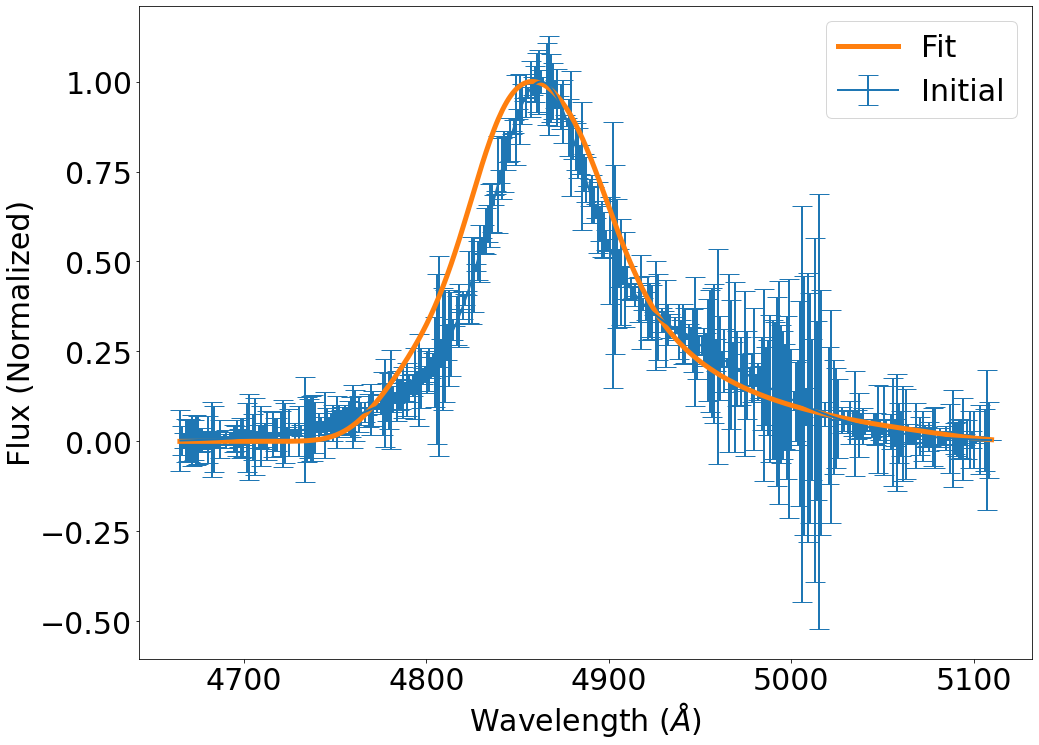

In [49]:
initial_w, initial_fl = disk(values_nostring)

MEK: Establish prior hypercube

In [ ]:
def my_prior_transform(cube):
    params = cube.copy()
    
    # Q1 uniform prior
    lo = 1.0
    hi = 2.0
    params[0] = cube[0] * (hi - lo) + lo

    # Q2 uniform prior
    #lo = 1.0
    #hi = 2.0
    #params[1] = cube[1] * (hi - lo) + lo

    # XIB uniform prior
    #lo = 1000
    #hi = 1050
    #params[2] = cube[2] * (hi - lo) + lo
    
    # ANGI uniform prior
    lo = 10.
    hi = 30.
    params[1] = cube[1] * (hi - lo) + lo

    # XI1 uniform prior
    lo = 2
    hi = 4
    params[2] = cube[2] * (hi - lo) + lo
    
    # XI2 uniform prior
    #lo = 100
    #hi = 20000
    #params[5] = cube[5] * (hi - lo) + lo

    # DELTA_XI uniform prior
    lo = 2.
    hi = 4.
    params[3] = cube[3] * (hi - lo) + lo

    # BROAD uniform prior
    #lo = 100.
    #hi = 2000.
    #params[6] = cube[6] * (hi - lo) + lo
    
    # T0 uniform prior
    #lo = 0.
    #hi = 0.001
    #params[7] = cube[7] * (hi - lo) + lo

    # ETA uniform prior
    #lo = -0.1
    #hi = 1.
    #params[8] = cube[8] * (hi - lo) + lo

    # ANGLAM uniform prior
    #lo = 0.
    #hi = 90.
    #params[9] = cube[9] * (hi - lo) + lo

    # AMP uniform prior
    #lo = 0.
    #hi = 10.
    #params[10] = cube[10] * (hi - lo) + lo

    # NARMS uniform prior
    #lo = 0
    #hi = 10
    #params[11] = cube[11] * (hi - lo) + lo

    # AOBS uniform prior
    #lo = -360.
    #hi = 360.
    #params[12] = cube[12] * (hi - lo) + lo

    # PITCH uniform prior
    #lo = -90.
    #hi = 90.
    #params[13] = cube[13] * (hi - lo) + lo

    # WIDTH uniform prior
    #lo = 0.
    #hi = 90.
    #params[14] = cube[14] * (hi - lo) + lo

    # XISPIN uniform prior
    #lo = 100
    #hi = 20000
    #params[15] = cube[15] * (hi - lo) + lo

    # XISPOUT uniform prior
    #lo = 100
    #hi = 20000
    #params[16] = cube[16] * (hi - lo) + lo

    return params

MEK: Initialize sampler

In [ ]:
sampler = ultranest.ReactiveNestedSampler(params_nostring, logL, my_prior_transform)

MEK: Pick 600 live points, run sampler

In [ ]:
result = sampler.run(min_num_live_points=600)
sampler.print_results()

MEK: Plot the final fit

In [ ]:
ultranest_final_params = sampler.results['posterior']['mean']
plot = disk(ultranest_final_params)

In [ ]:
MEK: Visualize corner plot

In [ ]:
from ultranest.plot import cornerplot
fig = cornerplot(result)
fig.savefig("./56449_corner.png")

MEK: Grab log evidence and calculate Bayes factor

In [ ]:
#logz_wind = result['logz']
#logz_wind

In [ ]:
#logz_nowind = result['logz']
#logz_nowind

In [ ]:
#bayes = np.exp(logz_wind-logz_nowind)
#bayes